# Markdown 

io-biodiversity dataset: Biodiversity Intactness Dataset by Impact Observatory and Vizzuality.


Shapefile (tl_2016_04_tract.shp): Census tract boundaries for Arizona from the U.S. Census Bureau.

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
import pystac_client
import planetary_computer
import contextily as ctx

In [5]:
from pystac_client import Client  # To access STAC catalogs

import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images

# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

biodiversity = catalog.get_child('io-biodiversity')
biodiversity

<CollectionClient id=io-biodiversity>

In [7]:
# Temporal range of interest
time_range = "2020-01-01/2020-12-31"

# Pheonix bounding box 
bbox = {
    "type": "Polygon",
    "coordinates": [
        [
            [-112.826843, 32.974108],  # Bottom-left corner
            [-112.826843, 33.863574],  # Top-left corner
            [-111.184387, 33.863574],  # Top-right corner
            [-111.184387, 32.974108],  # Bottom-right corner
            [-112.826843, 32.974108],  # Closing the polygon
        ]
    ],
}
    
# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    intersects = bbox,
    datetime = time_range)
search

# Retrieve search items
items = search.item_collection()
len(items)

1

In [4]:
# Get first item in the catalog search
item = items[0]
type(item)

pystac.item.Item

In [5]:
# Print item ID and properties
print('ID:' , item.id)
item.properties

ID: bii_2020_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2020-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2020-01-01T00:00:00Z'}

In [6]:
item.assets

{'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2020/bii_2020_34.74464974521749_-115.38597824385106_cog.tif?st=2024-12-05T21%3A51%3A26Z&se=2024-12-06T22%3A36%3A26Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-12-06T15%3A54%3A46Z&ske=2024-12-13T15%3A54%3A46Z&sks=b&skv=2024-05-04&sig=7oTR9OZ8GZCezmlScDWVeh1N1kY/f%2B%2BT9F3N2njfNvQ%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=

In [7]:
for key in item.assets.keys():
    print(key, '--', item.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [7]:
# Plot rendered preview
Image(url=item.assets['rendered_preview'].href, width=500)

In [8]:
print(item.assets.keys())

dict_keys(['data', 'tilejson', 'rendered_preview'])


In [9]:
sb = rioxr.open_rasterio(item.assets['data'].href)

In [10]:
print(sb)

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0


In [8]:
# Access the 2020 and 2017 items
item_2020 = catalog.search(
    collections=["io-biodiversity"],
    intersects=bbox,
    datetime="2020-01-01/2020-12-31"
).item_collection()[0]

item_2017 = catalog.search(
    collections=["io-biodiversity"],
    intersects=bbox,
    datetime="2017-01-01/2017-12-31"
).item_collection()[0]


In [9]:
# Correct the file path
gdf = gpd.read_file('data/tl_2016_04_tract.shp')

# Print first few rows to check the data
print(gdf.head())

  STATEFP COUNTYFP TRACTCE        GEOID   NAME            NAMELSAD  MTFCC  \
0      04      019  003003  04019003003  30.03  Census Tract 30.03  G5020   
1      04      019  003707  04019003707  37.07  Census Tract 37.07  G5020   
2      04      019  004067  04019004067  40.67  Census Tract 40.67  G5020   
3      04      019  003303  04019003303  33.03  Census Tract 33.03  G5020   
4      04      019  003706  04019003706  37.06  Census Tract 37.06  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  2053859       0  +32.2471612  -110.8661956   
1        S  1522786       0  +32.1518292  -110.9522877   
2        S  1851359       0  +32.2405665  -110.8490480   
3        S  3004756       0  +32.2206105  -110.8666444   
4        S  1371062       0  +32.1596545  -110.9523196   

                                            geometry  
0  POLYGON ((-110.87984 32.24926, -110.87983 32.2...  
1  POLYGON ((-110.96121 32.15597, -110.96106 32.1...  
2  POLYGON ((-110.85792

<Axes: >

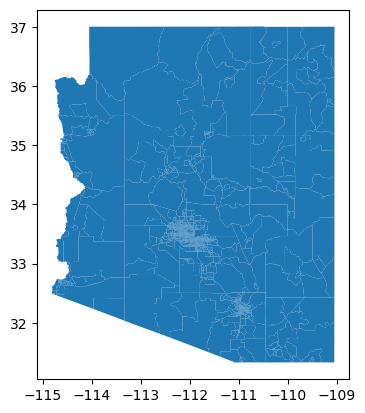

In [12]:
gdf.plot()

In [10]:
# Filter for Maricopa County (Phoenix area)
maricopa = gdf[gdf['COUNTYFP'] == "013"]

<Axes: >

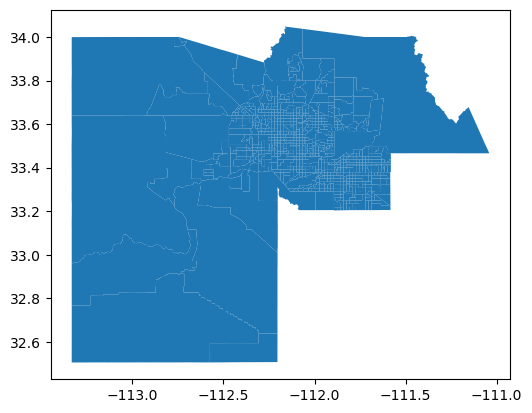

In [11]:
maricopa.plot()

In [12]:
# Check CRS of the Maricopa GeoDataFrame
print(maricopa.crs)

# Reproject to match the biodiversity dataset CRS
maricopa = maricopa.to_crs("EPSG:4326")

EPSG:4269


In [17]:
print(biodiversity.dims)
print(biodiversity.coords)

('band', 'y', 'x')
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


In [15]:
# Load the raster data for 2020
rast_2020 = rioxr.open_rasterio(item_2020.assets["data"].href)
rast_2020 = rast_2020.squeeze().drop_vars("band")

In [16]:
rast_2017 = rioxr.open_rasterio(item_2017.assets["data"].href)
rast_2017 = rast_2017.squeeze().drop_vars("band")

In [17]:
# Clip the raster data to the Maricopa County boundary for 2020 and 2017
maricopa_clip_2020 = (rast_2020.rio.clip_box(*maricopa.total_bounds)
                      .rio.clip(maricopa.geometry))
maricopa_clip_2017 = (rast_2017.rio.clip_box(*maricopa.total_bounds)
                      .rio.clip(maricopa.geometry))

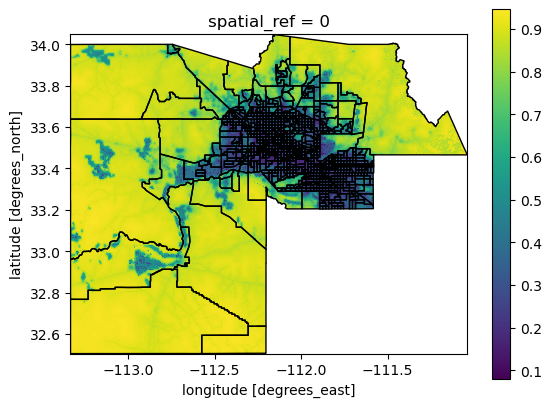

In [18]:
# Plot the clipped raster with the Maricopa County shapefile boundary
fig, ax = plt.subplots()
maricopa_clip_2020.plot(ax=ax)
maricopa.plot(ax=ax, color=(0.1, 0.2, 0.5, 0.01), edgecolor="black")
plt.show()

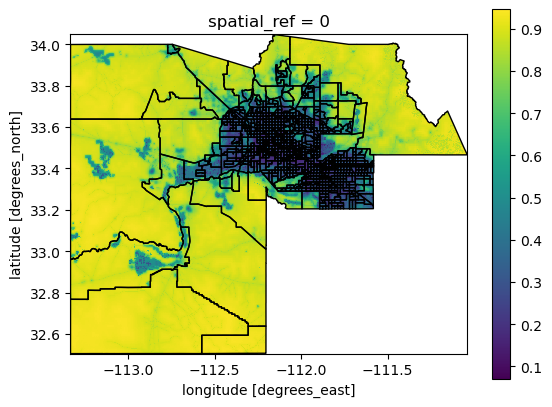

In [19]:
# Plot the clipped raster with the Maricopa County shapefile boundary
fig, ax = plt.subplots()
maricopa_clip_2017.plot(ax=ax)
maricopa.plot(ax=ax, color=(0.1, 0.2, 0.5, 0.01), edgecolor="black")
plt.show()

In [20]:
# Convert to boolean arrays for BII >= 0.75
bii_2020_high = (maricopa_clip_2020 >= 0.75).astype(int)
bii_2017_high = (maricopa_clip_2017 >= 0.75).astype(int)

In [21]:
# Find the total number of pixels for each year
total_pixels_2020 = bii_2020_high.count().item()
total_pixels_2017 = bii_2017_high.count().item()

In [22]:
# Find count of pixels above 0.75 BII for each year
bii_pixels_2020 = bii_2020_high.values.sum()
bii_pixels_2017 = bii_2017_high.values.sum()

In [23]:
# Calculate percentages
bii_pct_2020 = (bii_pixels_2020 / total_pixels_2020) * 100
bii_pct_2017 = (bii_pixels_2017 / total_pixels_2017) * 100

In [24]:
print(f"In 2017, {round(bii_pct_2017, 2)}% of Maricopa County had a BII of at least 0.75")
print(f"In 2020, {round(bii_pct_2020, 2)}% of Maricopa County had a BII of at least 0.75")


In 2017, 49.66% of Maricopa County had a BII of at least 0.75
In 2020, 49.11% of Maricopa County had a BII of at least 0.75


In [25]:
# Calculate the difference in pixels above 0.75 from 2017 to 2020
diff_2017_2020 = bii_2017_high - bii_2020_high


In [26]:
# Set all that are not 1 to NA (pixels that fell below threshold)
loss_2017_2020 = diff_2017_2020.where(diff_2017_2020 == 1)

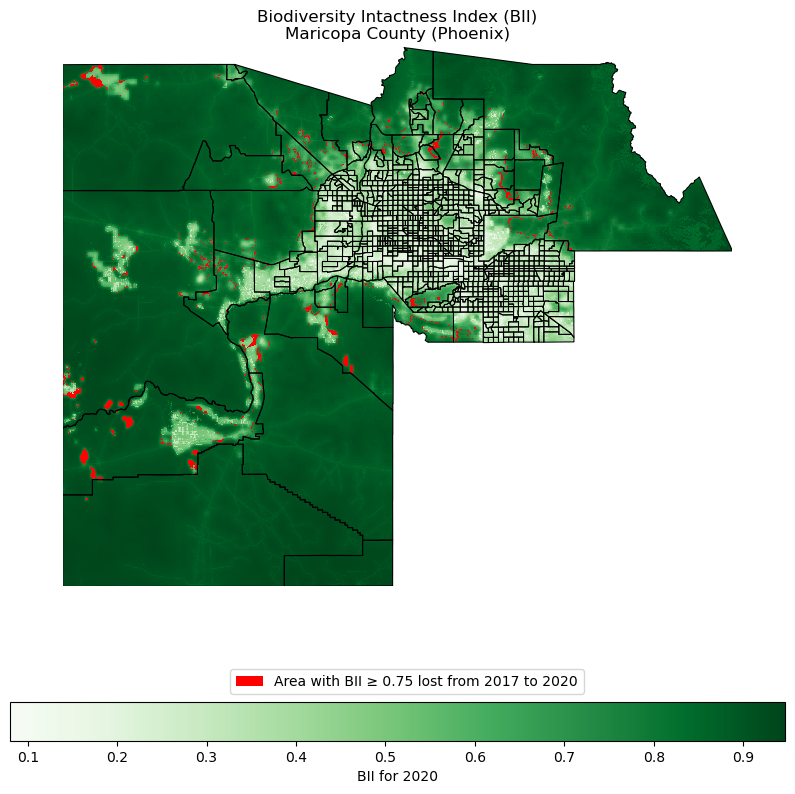

In [31]:
# Create map
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

# Plot BII for 2020
maricopa_clip_2020.plot(ax=ax, cmap='Greens', cbar_kwargs={'orientation': 'horizontal', 'label': 'BII for 2020'})

# Plot BII loss
loss_2017_2020.plot(ax=ax, cmap='brg', add_colorbar=False)

# Plot Maricopa boundary
maricopa.plot(ax=ax, color='none', edgecolor='black', linewidth=0.75)

# Add legend
legend = [mpatches.Patch(facecolor='red', label='Area with BII ≥ 0.75 lost from 2017 to 2020')]
ax.legend(handles=legend, loc=(0.25, -0.2))

# Set title
ax.set_title("Biodiversity Intactness Index (BII)\nMaricopa County (Phoenix)")

# Show plot (no saving)
plt.show()
